<a href="https://colab.research.google.com/github/Prajay404/QCNNFORQSO/blob/main/X_ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch [20/60], Train Loss: 0.5532, Val Loss: 0.5648
Epoch [40/60], Train Loss: 0.2112, Val Loss: 0.0685
Epoch [60/60], Train Loss: 0.1445, Val Loss: 0.0266
Mean Squared Error: 7248471.0000
Root Mean Squared Error: 2692.2985
R2 Score: 0.9122
Mean Absolute Percentage Error: 0.2784

Random Forest Results:
Mean Squared Error: 8692929.4159
Root Mean Squared Error: 2948.3774
R2 Score: 0.8947
Mean Absolute Percentage Error: 0.0628


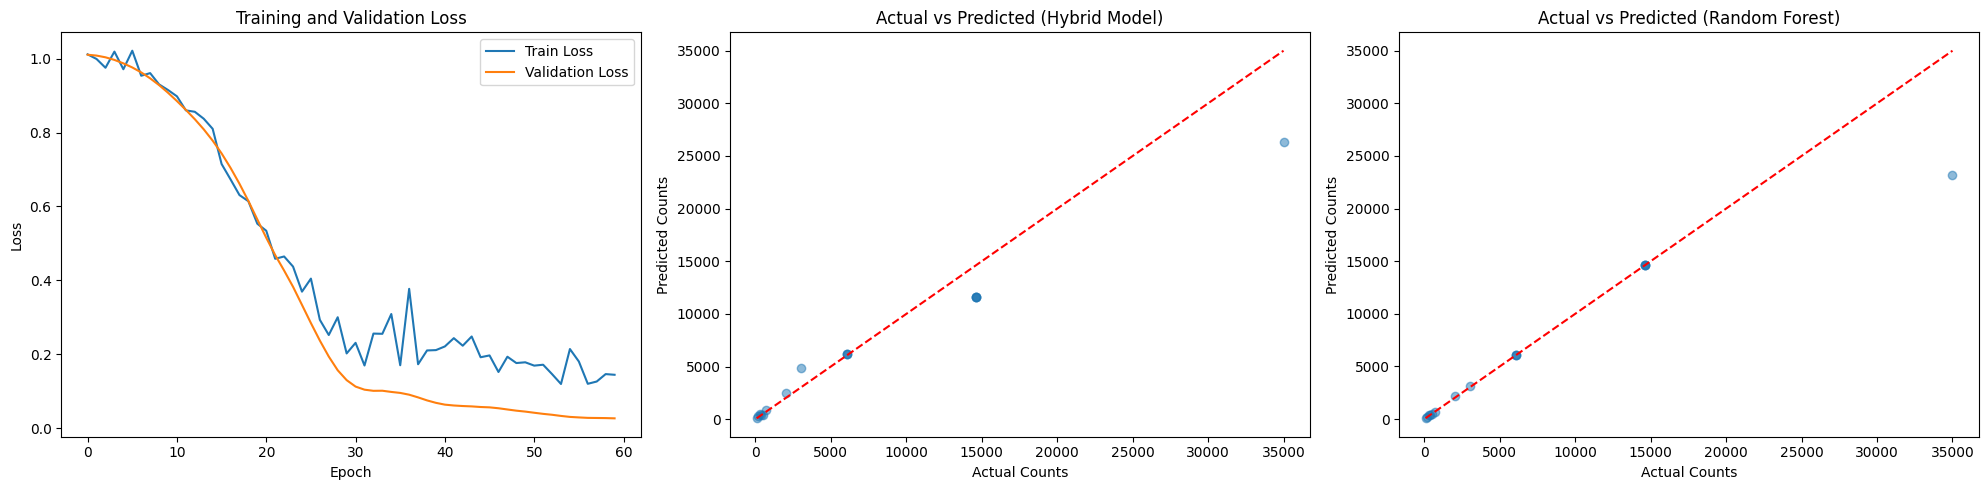

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import pennylane as qml
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, mutual_info_regression

# Load and preprocess the data
df = pd.read_csv('/content/xrayquasaragn (3) (1).csv', sep=';')
features = ['a_ra', 'a_dec', 'a_snr', 'b_ra', 'b_dec']
X = df[features].copy()
y = df['a_counts']

# Advanced feature engineering
X['ra_dec_diff'] = X['a_ra'] - X['a_dec']
X['ra_dec_product'] = X['a_ra'] * X['a_dec']
X['snr_squared'] = X['a_snr'] ** 2
X['ra_dec_ratio'] = X['a_ra'] / (X['a_dec'] + 1e-8)
X['snr_ra_ratio'] = X['a_snr'] / (X['a_ra'] + 1e-8)
X['snr_dec_ratio'] = X['a_snr'] / (X['a_dec'] + 1e-8)
X['log_snr'] = np.log1p(X['a_snr'])

# Feature selection using mutual information
selector = SelectKBest(mutual_info_regression, k=10)  # Increased to 10 features
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()].tolist()

# Log transform the target variable
y_log = np.log1p(y)

# Scale features and log-transformed target
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X_selected)
y_scaled = scaler_y.fit_transform(y_log.values.reshape(-1, 1))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define the quantum device
n_qubits = X_selected.shape[1]
dev = qml.device("default.qubit", wires=n_qubits)

# Define a more complex quantum circuit
@qml.qnode(dev)
def quantum_circuit(inputs, weights1, weights2, weights3):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights1, wires=range(n_qubits))
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights2, wires=range(n_qubits))
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights3, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Define a hybrid quantum-classical model
class HybridModel(nn.Module):
    def __init__(self, n_qubits, n_layers):
        super().__init__()
        self.n_qubits = n_qubits
        self.q_layers1 = nn.Parameter(torch.randn(n_layers, n_qubits, 3))
        self.q_layers2 = nn.Parameter(torch.randn(n_layers, n_qubits, 3))
        self.q_layers3 = nn.Parameter(torch.randn(n_layers, n_qubits, 3))
        self.classical_layers = nn.Sequential(
            nn.Linear(n_qubits * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        quantum_out = torch.tensor([quantum_circuit(x_i, self.q_layers1, self.q_layers2, self.q_layers3) for x_i in x], dtype=torch.float32)
        combined = torch.cat((x, quantum_out), dim=1)
        return self.classical_layers(combined)

# Initialize the model
model = HybridModel(n_qubits=n_qubits, n_layers=5)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Custom learning rate scheduler
def cosine_annealing_with_warmup(optimizer, num_epochs, warmup_epochs):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return epoch / warmup_epochs
        return 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / (num_epochs - warmup_epochs)))
    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

scheduler = cosine_annealing_with_warmup(optimizer, num_epochs=200, warmup_epochs=20)

# Training loop
n_epochs = 60
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test)
        val_loss = criterion(val_outputs, y_test)
        val_losses.append(val_loss.item())

    scheduler.step()

    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

# Final evaluation
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test)
    y_pred_log = scaler_y.inverse_transform(y_pred_scaled.numpy())
    y_pred = np.expm1(y_pred_log)
    y_test_log = scaler_y.inverse_transform(y_test.numpy())
    y_test_unscaled = np.expm1(y_test_log)

    mse = mean_squared_error(y_test_unscaled, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_unscaled, y_pred)
    mape = mean_absolute_percentage_error(y_test_unscaled, y_pred)

    print(f'Mean Squared Error: {mse:.4f}')
    print(f'Root Mean Squared Error: {rmse:.4f}')
    print(f'R2 Score: {r2:.4f}')
    print(f'Mean Absolute Percentage Error: {mape:.4f}')

# Compare with Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train.numpy(), y_train.numpy().flatten())
rf_pred = rf_model.predict(X_test.numpy())
rf_pred = np.expm1(scaler_y.inverse_transform(rf_pred.reshape(-1, 1)))

rf_mse = mean_squared_error(y_test_unscaled, rf_pred)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test_unscaled, rf_pred)
rf_mape = mean_absolute_percentage_error(y_test_unscaled, rf_pred)

print("\nRandom Forest Results:")
print(f'Mean Squared Error: {rf_mse:.4f}')
print(f'Root Mean Squared Error: {rf_rmse:.4f}')
print(f'R2 Score: {rf_r2:.4f}')
print(f'Mean Absolute Percentage Error: {rf_mape:.4f}')

# Visualizations
plt.figure(figsize=(20, 5))

# Loss plot
plt.subplot(131)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Actual vs Predicted (Hybrid Model)
plt.subplot(132)
plt.scatter(y_test_unscaled, y_pred, alpha=0.5)
plt.plot([y_test_unscaled.min(), y_test_unscaled.max()], [y_test_unscaled.min(), y_test_unscaled.max()], 'r--')
plt.xlabel('Actual Counts')
plt.ylabel('Predicted Counts')
plt.title('Actual vs Predicted (Hybrid Model)')

# Actual vs Predicted (Random Forest)
plt.subplot(133)
plt.scatter(y_test_unscaled, rf_pred, alpha=0.5)
plt.plot([y_test_unscaled.min(), y_test_unscaled.max()], [y_test_unscaled.min(), y_test_unscaled.max()], 'r--')
plt.xlabel('Actual Counts')
plt.ylabel('Predicted Counts')
plt.title('Actual vs Predicted (Random Forest)')

plt.tight_layout()
plt.show()


In [ ]:
%pip install pennylane


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 52.1 MB/s eta 0:00:00
